In [2]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime

import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [2]:
start_time = time.time()
args = arguments()
#boardio is for the the tensorboardx prensation and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





{'exp_name': 'random selection', 'eval': False, 'data': 'mnist', 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size': 1000, 'model': 'cnn2', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 200, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon': 4, 'optimizer': 'sgd', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': True, 'device': 'cpu', 'seed': 0, 'zeta_coeff': 1.5, 'alpha': 1, 'beta': 2, 'gamma': 1, 'max_seconds': 200, 'method_choosing_users': 'random', 'data_truncation': 900, 'choosing_users_verbose': False}


In [3]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'mnist':
        raise ValueError('CNN3 is not supported for MNIST')
    global_model = models.CNN3Layer()
elif args.model == 'cnn5':
    if args.data == 'mnist':
        raise ValueError('CNN3 is not supported for MNIST')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model.to(args.device)

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)



Layer (type:depth-idx)                   Param #
CNN2Layer                                --
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            906
├─Linear: 1-3                            4,850
├─Linear: 1-4                            510
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
Total params: 6,422
Trainable params: 6,422
Non-trainable params: 0


  0%|          | 1/200 [00:05<16:52,  5.09s/it]

global epoch 1 has been done artifficialy in 0.90 secs, the total time by now is 0.90 
 with avg train loss 2.297, avg val loss 2.299, avg val acc 10.67%


  1%|          | 2/200 [00:10<16:33,  5.02s/it]

global epoch 2 has been done artifficialy in 0.90 secs, the total time by now is 1.80 
 with avg train loss 2.297, avg val loss 2.299, avg val acc 11.03%


  2%|▏         | 3/200 [00:15<16:38,  5.07s/it]

global epoch 3 has been done artifficialy in 0.90 secs, the total time by now is 2.69 
 with avg train loss 2.298, avg val loss 2.298, avg val acc 11.70%


  2%|▏         | 4/200 [00:20<16:39,  5.10s/it]

global epoch 4 has been done artifficialy in 0.81 secs, the total time by now is 3.51 
 with avg train loss 2.301, avg val loss 2.297, avg val acc 11.75%


  2%|▎         | 5/200 [00:25<16:42,  5.14s/it]

global epoch 5 has been done artifficialy in 0.87 secs, the total time by now is 4.38 
 with avg train loss 2.298, avg val loss 2.296, avg val acc 12.14%


  3%|▎         | 6/200 [00:30<16:30,  5.11s/it]

global epoch 6 has been done artifficialy in 0.86 secs, the total time by now is 5.24 
 with avg train loss 2.289, avg val loss 2.296, avg val acc 12.18%


  4%|▎         | 7/200 [00:35<15:48,  4.91s/it]

global epoch 7 has been done artifficialy in 0.80 secs, the total time by now is 6.04 
 with avg train loss 2.305, avg val loss 2.295, avg val acc 12.49%


  4%|▍         | 8/200 [00:39<15:16,  4.77s/it]

global epoch 8 has been done artifficialy in 0.76 secs, the total time by now is 6.79 
 with avg train loss 2.285, avg val loss 2.294, avg val acc 12.21%


  4%|▍         | 9/200 [00:43<14:48,  4.65s/it]

global epoch 9 has been done artifficialy in 0.92 secs, the total time by now is 7.71 
 with avg train loss 2.303, avg val loss 2.293, avg val acc 13.78%


  5%|▌         | 10/200 [00:48<14:26,  4.56s/it]

global epoch 10 has been done artifficialy in 0.83 secs, the total time by now is 8.54 
 with avg train loss 2.304, avg val loss 2.292, avg val acc 14.84%


  6%|▌         | 11/200 [00:52<14:11,  4.50s/it]

global epoch 11 has been done artifficialy in 0.90 secs, the total time by now is 9.44 
 with avg train loss 2.284, avg val loss 2.292, avg val acc 15.01%


  6%|▌         | 12/200 [00:57<14:03,  4.49s/it]

global epoch 12 has been done artifficialy in 0.78 secs, the total time by now is 10.22 
 with avg train loss 2.280, avg val loss 2.291, avg val acc 15.43%


  6%|▋         | 13/200 [01:01<13:59,  4.49s/it]

global epoch 13 has been done artifficialy in 0.82 secs, the total time by now is 11.05 
 with avg train loss 2.302, avg val loss 2.290, avg val acc 16.45%


  7%|▋         | 14/200 [01:06<13:54,  4.48s/it]

global epoch 14 has been done artifficialy in 0.83 secs, the total time by now is 11.88 
 with avg train loss 2.288, avg val loss 2.289, avg val acc 16.61%


  8%|▊         | 15/200 [01:10<13:39,  4.43s/it]

global epoch 15 has been done artifficialy in 0.89 secs, the total time by now is 12.77 
 with avg train loss 2.266, avg val loss 2.288, avg val acc 16.74%


  8%|▊         | 16/200 [01:14<13:34,  4.43s/it]

global epoch 16 has been done artifficialy in 0.90 secs, the total time by now is 13.66 
 with avg train loss 2.297, avg val loss 2.287, avg val acc 16.82%


  8%|▊         | 17/200 [01:19<13:24,  4.40s/it]

global epoch 17 has been done artifficialy in 0.80 secs, the total time by now is 14.46 
 with avg train loss 2.284, avg val loss 2.286, avg val acc 17.17%


  9%|▉         | 18/200 [01:23<13:22,  4.41s/it]

global epoch 18 has been done artifficialy in 0.91 secs, the total time by now is 15.38 
 with avg train loss 2.261, avg val loss 2.285, avg val acc 17.29%


 10%|▉         | 19/200 [01:27<13:12,  4.38s/it]

global epoch 19 has been done artifficialy in 0.89 secs, the total time by now is 16.27 
 with avg train loss 2.299, avg val loss 2.285, avg val acc 17.31%


 10%|█         | 20/200 [01:32<13:10,  4.39s/it]

global epoch 20 has been done artifficialy in 0.84 secs, the total time by now is 17.11 
 with avg train loss 2.286, avg val loss 2.284, avg val acc 17.34%


 10%|█         | 21/200 [01:36<13:00,  4.36s/it]

global epoch 21 has been done artifficialy in 0.90 secs, the total time by now is 18.01 
 with avg train loss 2.280, avg val loss 2.283, avg val acc 18.01%


 11%|█         | 22/200 [01:41<13:00,  4.38s/it]

global epoch 22 has been done artifficialy in 0.85 secs, the total time by now is 18.86 
 with avg train loss 2.287, avg val loss 2.282, avg val acc 17.53%


 12%|█▏        | 23/200 [01:45<12:55,  4.38s/it]

global epoch 23 has been done artifficialy in 0.81 secs, the total time by now is 19.67 
 with avg train loss 2.278, avg val loss 2.281, avg val acc 18.22%


 12%|█▏        | 24/200 [01:49<12:53,  4.39s/it]

global epoch 24 has been done artifficialy in 0.90 secs, the total time by now is 20.58 
 with avg train loss 2.277, avg val loss 2.280, avg val acc 18.27%


 12%|█▎        | 25/200 [01:54<12:57,  4.45s/it]

global epoch 25 has been done artifficialy in 0.86 secs, the total time by now is 21.44 
 with avg train loss 2.275, avg val loss 2.278, avg val acc 17.86%


 13%|█▎        | 26/200 [01:58<12:54,  4.45s/it]

global epoch 26 has been done artifficialy in 0.88 secs, the total time by now is 22.32 
 with avg train loss 2.263, avg val loss 2.277, avg val acc 17.97%


 14%|█▎        | 27/200 [02:03<12:46,  4.43s/it]

global epoch 27 has been done artifficialy in 0.79 secs, the total time by now is 23.11 
 with avg train loss 2.267, avg val loss 2.276, avg val acc 17.97%


 14%|█▍        | 28/200 [02:07<12:42,  4.43s/it]

global epoch 28 has been done artifficialy in 0.89 secs, the total time by now is 24.00 
 with avg train loss 2.279, avg val loss 2.275, avg val acc 18.04%


 14%|█▍        | 29/200 [02:12<12:39,  4.44s/it]

global epoch 29 has been done artifficialy in 0.87 secs, the total time by now is 24.87 
 with avg train loss 2.257, avg val loss 2.274, avg val acc 18.41%


 15%|█▌        | 30/200 [02:16<12:34,  4.44s/it]

global epoch 30 has been done artifficialy in 0.88 secs, the total time by now is 25.75 
 with avg train loss 2.266, avg val loss 2.273, avg val acc 18.86%


 16%|█▌        | 31/200 [02:21<12:40,  4.50s/it]

global epoch 31 has been done artifficialy in 0.83 secs, the total time by now is 26.58 
 with avg train loss 2.291, avg val loss 2.271, avg val acc 19.10%


 16%|█▌        | 32/200 [02:25<12:44,  4.55s/it]

global epoch 32 has been done artifficialy in 0.83 secs, the total time by now is 27.41 
 with avg train loss 2.286, avg val loss 2.269, avg val acc 19.18%


 16%|█▋        | 33/200 [02:30<12:34,  4.52s/it]

global epoch 33 has been done artifficialy in 0.91 secs, the total time by now is 28.31 
 with avg train loss 2.255, avg val loss 2.267, avg val acc 18.06%


 17%|█▋        | 34/200 [02:34<12:22,  4.47s/it]

global epoch 34 has been done artifficialy in 0.85 secs, the total time by now is 29.16 
 with avg train loss 2.271, avg val loss 2.265, avg val acc 16.99%


 18%|█▊        | 35/200 [02:39<12:16,  4.46s/it]

global epoch 35 has been done artifficialy in 0.89 secs, the total time by now is 30.06 
 with avg train loss 2.260, avg val loss 2.264, avg val acc 16.99%


 18%|█▊        | 36/200 [02:43<12:05,  4.42s/it]

global epoch 36 has been done artifficialy in 0.84 secs, the total time by now is 30.90 
 with avg train loss 2.272, avg val loss 2.262, avg val acc 18.22%


 18%|█▊        | 37/200 [02:47<12:01,  4.43s/it]

global epoch 37 has been done artifficialy in 0.84 secs, the total time by now is 31.75 
 with avg train loss 2.262, avg val loss 2.261, avg val acc 20.58%


 19%|█▉        | 38/200 [02:52<11:52,  4.40s/it]

global epoch 38 has been done artifficialy in 0.88 secs, the total time by now is 32.62 
 with avg train loss 2.275, avg val loss 2.259, avg val acc 20.55%


 20%|█▉        | 39/200 [02:56<11:46,  4.39s/it]

global epoch 39 has been done artifficialy in 0.86 secs, the total time by now is 33.48 
 with avg train loss 2.232, avg val loss 2.256, avg val acc 19.80%


 20%|██        | 40/200 [03:01<11:46,  4.42s/it]

global epoch 40 has been done artifficialy in 0.72 secs, the total time by now is 34.19 
 with avg train loss 2.264, avg val loss 2.254, avg val acc 21.23%


 20%|██        | 41/200 [03:05<11:46,  4.44s/it]

global epoch 41 has been done artifficialy in 0.92 secs, the total time by now is 35.12 
 with avg train loss 2.235, avg val loss 2.252, avg val acc 21.44%


 21%|██        | 42/200 [03:10<11:41,  4.44s/it]

global epoch 42 has been done artifficialy in 0.87 secs, the total time by now is 35.99 
 with avg train loss 2.246, avg val loss 2.250, avg val acc 22.22%


 22%|██▏       | 43/200 [03:14<11:39,  4.45s/it]

global epoch 43 has been done artifficialy in 0.88 secs, the total time by now is 36.87 
 with avg train loss 2.238, avg val loss 2.248, avg val acc 22.80%


 22%|██▏       | 44/200 [03:18<11:28,  4.41s/it]

global epoch 44 has been done artifficialy in 0.76 secs, the total time by now is 37.63 
 with avg train loss 2.264, avg val loss 2.245, avg val acc 23.67%


 22%|██▎       | 45/200 [03:23<11:22,  4.40s/it]

global epoch 45 has been done artifficialy in 0.81 secs, the total time by now is 38.44 
 with avg train loss 2.246, avg val loss 2.243, avg val acc 23.25%


 23%|██▎       | 46/200 [03:27<11:18,  4.41s/it]

global epoch 46 has been done artifficialy in 0.85 secs, the total time by now is 39.29 
 with avg train loss 2.255, avg val loss 2.240, avg val acc 23.49%


 24%|██▎       | 47/200 [03:32<11:13,  4.40s/it]

global epoch 47 has been done artifficialy in 0.85 secs, the total time by now is 40.14 
 with avg train loss 2.241, avg val loss 2.238, avg val acc 23.87%


 24%|██▍       | 48/200 [03:36<11:04,  4.37s/it]

global epoch 48 has been done artifficialy in 0.87 secs, the total time by now is 41.01 
 with avg train loss 2.250, avg val loss 2.236, avg val acc 22.96%


 24%|██▍       | 49/200 [03:40<11:00,  4.37s/it]

global epoch 49 has been done artifficialy in 0.88 secs, the total time by now is 41.89 
 with avg train loss 2.234, avg val loss 2.233, avg val acc 23.38%


 25%|██▌       | 50/200 [03:45<11:00,  4.40s/it]

global epoch 50 has been done artifficialy in 0.70 secs, the total time by now is 42.60 
 with avg train loss 2.221, avg val loss 2.229, avg val acc 24.65%


 26%|██▌       | 51/200 [03:49<11:03,  4.46s/it]

global epoch 51 has been done artifficialy in 0.94 secs, the total time by now is 43.53 
 with avg train loss 2.244, avg val loss 2.226, avg val acc 24.62%


 26%|██▌       | 52/200 [03:54<10:54,  4.42s/it]

global epoch 52 has been done artifficialy in 0.82 secs, the total time by now is 44.36 
 with avg train loss 2.221, avg val loss 2.222, avg val acc 25.42%


 26%|██▋       | 53/200 [03:58<10:43,  4.38s/it]

global epoch 53 has been done artifficialy in 0.83 secs, the total time by now is 45.18 
 with avg train loss 2.240, avg val loss 2.218, avg val acc 26.50%


 27%|██▋       | 54/200 [04:02<10:45,  4.42s/it]

global epoch 54 has been done artifficialy in 0.85 secs, the total time by now is 46.04 
 with avg train loss 2.241, avg val loss 2.215, avg val acc 26.87%


 28%|██▊       | 55/200 [04:07<10:41,  4.42s/it]

global epoch 55 has been done artifficialy in 0.90 secs, the total time by now is 46.93 
 with avg train loss 2.210, avg val loss 2.210, avg val acc 26.31%


 28%|██▊       | 56/200 [04:11<10:36,  4.42s/it]

global epoch 56 has been done artifficialy in 0.85 secs, the total time by now is 47.79 
 with avg train loss 2.193, avg val loss 2.205, avg val acc 24.70%


 28%|██▊       | 57/200 [04:16<10:45,  4.51s/it]

global epoch 57 has been done artifficialy in 0.90 secs, the total time by now is 48.68 
 with avg train loss 2.186, avg val loss 2.200, avg val acc 24.76%


 29%|██▉       | 58/200 [04:20<10:38,  4.49s/it]

global epoch 58 has been done artifficialy in 0.88 secs, the total time by now is 49.56 
 with avg train loss 2.181, avg val loss 2.195, avg val acc 23.70%
global epoch 59 has been done artifficialy in 0.85 secs, the total time by now is 50.41 
 with avg train loss 2.206, avg val loss 2.190, avg val acc 25.00%


 30%|███       | 60/200 [04:30<10:52,  4.66s/it]

global epoch 60 has been done artifficialy in 0.84 secs, the total time by now is 51.25 
 with avg train loss 2.223, avg val loss 2.185, avg val acc 27.54%


 30%|███       | 61/200 [04:34<10:33,  4.55s/it]

global epoch 61 has been done artifficialy in 0.89 secs, the total time by now is 52.14 
 with avg train loss 2.186, avg val loss 2.179, avg val acc 28.55%


 31%|███       | 62/200 [04:39<10:21,  4.50s/it]

global epoch 62 has been done artifficialy in 0.80 secs, the total time by now is 52.94 
 with avg train loss 2.192, avg val loss 2.174, avg val acc 30.69%


 32%|███▏      | 63/200 [04:43<10:10,  4.46s/it]

global epoch 63 has been done artifficialy in 0.18 secs, the total time by now is 53.13 
 with avg train loss 2.202, avg val loss 2.168, avg val acc 33.70%


 32%|███▏      | 64/200 [04:48<10:05,  4.45s/it]

global epoch 64 has been done artifficialy in 0.86 secs, the total time by now is 53.98 
 with avg train loss 2.158, avg val loss 2.161, avg val acc 32.25%


 32%|███▎      | 65/200 [04:52<10:03,  4.47s/it]

global epoch 65 has been done artifficialy in 0.88 secs, the total time by now is 54.86 
 with avg train loss 2.168, avg val loss 2.154, avg val acc 35.82%


 33%|███▎      | 66/200 [04:57<09:57,  4.46s/it]

global epoch 66 has been done artifficialy in 0.80 secs, the total time by now is 55.66 
 with avg train loss 2.163, avg val loss 2.148, avg val acc 35.26%


 34%|███▎      | 67/200 [05:01<09:53,  4.46s/it]

global epoch 67 has been done artifficialy in 0.75 secs, the total time by now is 56.41 
 with avg train loss 2.178, avg val loss 2.141, avg val acc 36.47%


 34%|███▍      | 68/200 [05:05<09:40,  4.40s/it]

global epoch 68 has been done artifficialy in 0.88 secs, the total time by now is 57.28 
 with avg train loss 2.143, avg val loss 2.132, avg val acc 37.39%


 34%|███▍      | 69/200 [05:10<09:36,  4.40s/it]

global epoch 69 has been done artifficialy in 0.86 secs, the total time by now is 58.15 
 with avg train loss 2.119, avg val loss 2.123, avg val acc 38.16%


 35%|███▌      | 70/200 [05:14<09:32,  4.40s/it]

global epoch 70 has been done artifficialy in 0.87 secs, the total time by now is 59.01 
 with avg train loss 2.114, avg val loss 2.113, avg val acc 40.48%


 36%|███▌      | 71/200 [05:19<09:28,  4.41s/it]

global epoch 71 has been done artifficialy in 0.86 secs, the total time by now is 59.88 
 with avg train loss 2.136, avg val loss 2.105, avg val acc 41.84%


 36%|███▌      | 72/200 [05:23<09:16,  4.35s/it]

global epoch 72 has been done artifficialy in 0.89 secs, the total time by now is 60.76 
 with avg train loss 2.126, avg val loss 2.096, avg val acc 44.35%


 36%|███▋      | 73/200 [05:27<09:13,  4.36s/it]

global epoch 73 has been done artifficialy in 0.81 secs, the total time by now is 61.57 
 with avg train loss 2.109, avg val loss 2.087, avg val acc 44.29%


 37%|███▋      | 74/200 [05:32<09:11,  4.38s/it]

global epoch 74 has been done artifficialy in 0.76 secs, the total time by now is 62.33 
 with avg train loss 2.134, avg val loss 2.076, avg val acc 46.69%


 38%|███▊      | 75/200 [05:36<09:05,  4.37s/it]

global epoch 75 has been done artifficialy in 0.86 secs, the total time by now is 63.19 
 with avg train loss 2.072, avg val loss 2.063, avg val acc 47.60%


 38%|███▊      | 76/200 [05:40<09:04,  4.39s/it]

global epoch 76 has been done artifficialy in 0.91 secs, the total time by now is 64.10 
 with avg train loss 2.097, avg val loss 2.052, avg val acc 48.48%


 38%|███▊      | 77/200 [05:45<08:59,  4.39s/it]

global epoch 77 has been done artifficialy in 0.92 secs, the total time by now is 65.02 
 with avg train loss 2.023, avg val loss 2.038, avg val acc 49.91%


 39%|███▉      | 78/200 [05:49<08:52,  4.37s/it]

global epoch 78 has been done artifficialy in 0.91 secs, the total time by now is 65.93 
 with avg train loss 2.030, avg val loss 2.024, avg val acc 51.01%


 40%|███▉      | 79/200 [05:53<08:48,  4.37s/it]

global epoch 79 has been done artifficialy in 0.88 secs, the total time by now is 66.80 
 with avg train loss 2.042, avg val loss 2.009, avg val acc 52.75%


 40%|████      | 80/200 [05:58<08:41,  4.35s/it]

global epoch 80 has been done artifficialy in 0.85 secs, the total time by now is 67.65 
 with avg train loss 2.024, avg val loss 1.993, avg val acc 53.12%


 40%|████      | 81/200 [06:02<08:42,  4.39s/it]

global epoch 81 has been done artifficialy in 0.81 secs, the total time by now is 68.46 
 with avg train loss 2.059, avg val loss 1.976, avg val acc 56.90%


 41%|████      | 82/200 [06:07<08:38,  4.39s/it]

global epoch 82 has been done artifficialy in 0.91 secs, the total time by now is 69.37 
 with avg train loss 1.947, avg val loss 1.957, avg val acc 55.43%


 42%|████▏     | 83/200 [06:11<08:37,  4.42s/it]

global epoch 83 has been done artifficialy in 0.94 secs, the total time by now is 70.31 
 with avg train loss 1.986, avg val loss 1.938, avg val acc 56.23%


 42%|████▏     | 84/200 [06:16<08:31,  4.41s/it]

global epoch 84 has been done artifficialy in 0.90 secs, the total time by now is 71.21 
 with avg train loss 1.926, avg val loss 1.916, avg val acc 56.24%


 42%|████▎     | 85/200 [06:20<08:29,  4.43s/it]

global epoch 85 has been done artifficialy in 0.89 secs, the total time by now is 72.10 
 with avg train loss 1.925, avg val loss 1.896, avg val acc 57.05%


 43%|████▎     | 86/200 [06:25<08:29,  4.47s/it]

global epoch 86 has been done artifficialy in 0.89 secs, the total time by now is 72.99 
 with avg train loss 1.916, avg val loss 1.876, avg val acc 54.58%


 44%|████▎     | 87/200 [06:29<08:25,  4.48s/it]

global epoch 87 has been done artifficialy in 0.88 secs, the total time by now is 73.87 
 with avg train loss 1.980, avg val loss 1.856, avg val acc 54.10%


 44%|████▍     | 88/200 [06:33<08:18,  4.45s/it]

global epoch 88 has been done artifficialy in 0.76 secs, the total time by now is 74.63 
 with avg train loss 1.883, avg val loss 1.827, avg val acc 55.23%


 44%|████▍     | 89/200 [06:38<08:13,  4.45s/it]

global epoch 89 has been done artifficialy in 0.90 secs, the total time by now is 75.53 
 with avg train loss 1.888, avg val loss 1.801, avg val acc 56.49%


 45%|████▌     | 90/200 [06:42<08:08,  4.44s/it]

global epoch 90 has been done artifficialy in 0.87 secs, the total time by now is 76.40 
 with avg train loss 1.791, avg val loss 1.772, avg val acc 57.05%


 46%|████▌     | 91/200 [06:47<08:01,  4.42s/it]

global epoch 91 has been done artifficialy in 0.18 secs, the total time by now is 76.58 
 with avg train loss 1.814, avg val loss 1.744, avg val acc 57.92%


 46%|████▌     | 92/200 [06:51<07:55,  4.40s/it]

global epoch 92 has been done artifficialy in 0.89 secs, the total time by now is 77.48 
 with avg train loss 1.835, avg val loss 1.721, avg val acc 57.99%


 46%|████▋     | 93/200 [06:55<07:47,  4.37s/it]

global epoch 93 has been done artifficialy in 0.86 secs, the total time by now is 78.33 
 with avg train loss 1.730, avg val loss 1.693, avg val acc 58.57%


 47%|████▋     | 94/200 [07:00<07:45,  4.40s/it]

global epoch 94 has been done artifficialy in 0.91 secs, the total time by now is 79.24 
 with avg train loss 1.713, avg val loss 1.667, avg val acc 59.04%


 48%|████▊     | 95/200 [07:04<07:41,  4.39s/it]

global epoch 95 has been done artifficialy in 0.86 secs, the total time by now is 80.10 
 with avg train loss 1.698, avg val loss 1.635, avg val acc 59.25%


 48%|████▊     | 96/200 [07:09<07:38,  4.41s/it]

global epoch 96 has been done artifficialy in 0.22 secs, the total time by now is 80.32 
 with avg train loss 1.808, avg val loss 1.603, avg val acc 59.85%


 48%|████▊     | 97/200 [07:13<07:31,  4.38s/it]

global epoch 97 has been done artifficialy in 0.87 secs, the total time by now is 81.19 
 with avg train loss 1.634, avg val loss 1.573, avg val acc 59.60%


 49%|████▉     | 98/200 [07:17<07:29,  4.41s/it]

global epoch 98 has been done artifficialy in 0.89 secs, the total time by now is 82.07 
 with avg train loss 1.678, avg val loss 1.545, avg val acc 59.87%


 50%|████▉     | 99/200 [07:22<07:24,  4.40s/it]

global epoch 99 has been done artifficialy in 0.91 secs, the total time by now is 82.99 
 with avg train loss 1.571, avg val loss 1.506, avg val acc 60.62%


 50%|█████     | 100/200 [07:26<07:17,  4.37s/it]

global epoch 100 has been done artifficialy in 0.89 secs, the total time by now is 83.88 
 with avg train loss 1.715, avg val loss 1.478, avg val acc 62.44%


 50%|█████     | 101/200 [07:30<07:11,  4.35s/it]

global epoch 101 has been done artifficialy in 0.87 secs, the total time by now is 84.75 
 with avg train loss 1.610, avg val loss 1.450, avg val acc 63.36%


 51%|█████     | 102/200 [07:35<07:06,  4.35s/it]

global epoch 102 has been done artifficialy in 0.80 secs, the total time by now is 85.55 
 with avg train loss 1.629, avg val loss 1.421, avg val acc 64.15%


 52%|█████▏    | 103/200 [07:39<07:02,  4.36s/it]

global epoch 103 has been done artifficialy in 0.84 secs, the total time by now is 86.40 
 with avg train loss 1.549, avg val loss 1.391, avg val acc 64.82%


 52%|█████▏    | 104/200 [07:43<06:57,  4.35s/it]

global epoch 104 has been done artifficialy in 0.86 secs, the total time by now is 87.26 
 with avg train loss 1.629, avg val loss 1.366, avg val acc 66.05%


 52%|█████▎    | 105/200 [07:48<06:52,  4.34s/it]

global epoch 105 has been done artifficialy in 0.18 secs, the total time by now is 87.43 
 with avg train loss 1.415, avg val loss 1.336, avg val acc 65.26%


 53%|█████▎    | 106/200 [07:52<06:47,  4.33s/it]

global epoch 106 has been done artifficialy in 0.93 secs, the total time by now is 88.36 
 with avg train loss 1.402, avg val loss 1.295, avg val acc 67.03%


 54%|█████▎    | 107/200 [07:56<06:41,  4.32s/it]

global epoch 107 has been done artifficialy in 0.83 secs, the total time by now is 89.19 
 with avg train loss 1.486, avg val loss 1.266, avg val acc 69.79%


 54%|█████▍    | 108/200 [08:01<06:37,  4.32s/it]

global epoch 108 has been done artifficialy in 0.82 secs, the total time by now is 90.01 
 with avg train loss 1.398, avg val loss 1.239, avg val acc 68.82%


 55%|█████▍    | 109/200 [08:05<06:32,  4.32s/it]

global epoch 109 has been done artifficialy in 0.85 secs, the total time by now is 90.86 
 with avg train loss 1.382, avg val loss 1.223, avg val acc 68.18%


 55%|█████▌    | 110/200 [08:09<06:29,  4.33s/it]

global epoch 110 has been done artifficialy in 0.85 secs, the total time by now is 91.71 
 with avg train loss 1.365, avg val loss 1.185, avg val acc 69.76%


 56%|█████▌    | 111/200 [08:14<06:24,  4.32s/it]

global epoch 111 has been done artifficialy in 0.86 secs, the total time by now is 92.57 
 with avg train loss 1.416, avg val loss 1.164, avg val acc 71.96%


 56%|█████▌    | 112/200 [08:18<06:21,  4.34s/it]

global epoch 112 has been done artifficialy in 0.81 secs, the total time by now is 93.38 
 with avg train loss 1.348, avg val loss 1.140, avg val acc 70.96%


 56%|█████▋    | 113/200 [08:22<06:17,  4.34s/it]

global epoch 113 has been done artifficialy in 0.18 secs, the total time by now is 93.56 
 with avg train loss 1.200, avg val loss 1.106, avg val acc 71.71%


 57%|█████▋    | 114/200 [08:27<06:12,  4.33s/it]

global epoch 114 has been done artifficialy in 0.79 secs, the total time by now is 94.35 
 with avg train loss 1.272, avg val loss 1.085, avg val acc 72.30%


 57%|█████▊    | 115/200 [08:31<06:07,  4.32s/it]

global epoch 115 has been done artifficialy in 0.90 secs, the total time by now is 95.26 
 with avg train loss 1.311, avg val loss 1.064, avg val acc 74.44%


 58%|█████▊    | 116/200 [08:35<06:06,  4.36s/it]

global epoch 116 has been done artifficialy in 0.86 secs, the total time by now is 96.11 
 with avg train loss 1.296, avg val loss 1.044, avg val acc 74.15%


 58%|█████▊    | 117/200 [08:40<06:01,  4.35s/it]

global epoch 117 has been done artifficialy in 0.88 secs, the total time by now is 96.99 
 with avg train loss 1.233, avg val loss 1.019, avg val acc 74.05%


 59%|█████▉    | 118/200 [08:44<05:57,  4.36s/it]

global epoch 118 has been done artifficialy in 0.89 secs, the total time by now is 97.88 
 with avg train loss 1.076, avg val loss 1.001, avg val acc 71.52%


 60%|█████▉    | 119/200 [08:49<05:55,  4.39s/it]

global epoch 119 has been done artifficialy in 0.88 secs, the total time by now is 98.76 
 with avg train loss 1.270, avg val loss 0.982, avg val acc 74.08%


 60%|██████    | 120/200 [08:53<05:56,  4.46s/it]

global epoch 120 has been done artifficialy in 0.87 secs, the total time by now is 99.63 
 with avg train loss 1.176, avg val loss 0.967, avg val acc 75.27%


 60%|██████    | 121/200 [08:58<05:48,  4.41s/it]

global epoch 121 has been done artifficialy in 0.83 secs, the total time by now is 100.46 
 with avg train loss 1.142, avg val loss 0.949, avg val acc 77.18%


 61%|██████    | 122/200 [09:02<05:39,  4.35s/it]

global epoch 122 has been done artifficialy in 0.90 secs, the total time by now is 101.35 
 with avg train loss 1.150, avg val loss 0.913, avg val acc 76.94%


 62%|██████▏   | 123/200 [09:06<05:38,  4.40s/it]

global epoch 123 has been done artifficialy in 0.89 secs, the total time by now is 102.25 
 with avg train loss 1.099, avg val loss 0.900, avg val acc 77.42%


 62%|██████▏   | 124/200 [09:11<05:34,  4.40s/it]

global epoch 124 has been done artifficialy in 0.90 secs, the total time by now is 103.15 
 with avg train loss 1.132, avg val loss 0.891, avg val acc 78.17%


 62%|██████▎   | 125/200 [09:15<05:28,  4.38s/it]

global epoch 125 has been done artifficialy in 0.85 secs, the total time by now is 104.00 
 with avg train loss 1.072, avg val loss 0.870, avg val acc 79.19%


 63%|██████▎   | 126/200 [09:19<05:24,  4.39s/it]

global epoch 126 has been done artifficialy in 0.82 secs, the total time by now is 104.82 
 with avg train loss 1.090, avg val loss 0.866, avg val acc 77.45%


 64%|██████▎   | 127/200 [09:24<05:19,  4.38s/it]

global epoch 127 has been done artifficialy in 0.92 secs, the total time by now is 105.73 
 with avg train loss 1.226, avg val loss 0.859, avg val acc 77.82%


 64%|██████▍   | 128/200 [09:29<05:29,  4.58s/it]

global epoch 128 has been done artifficialy in 0.89 secs, the total time by now is 106.63 
 with avg train loss 1.179, avg val loss 0.840, avg val acc 78.70%


 64%|██████▍   | 129/200 [09:34<05:30,  4.66s/it]

global epoch 129 has been done artifficialy in 0.90 secs, the total time by now is 107.53 
 with avg train loss 1.063, avg val loss 0.818, avg val acc 78.71%


 65%|██████▌   | 130/200 [09:38<05:27,  4.68s/it]

global epoch 130 has been done artifficialy in 0.80 secs, the total time by now is 108.33 
 with avg train loss 0.979, avg val loss 0.816, avg val acc 76.74%


 66%|██████▌   | 131/200 [09:43<05:28,  4.76s/it]

global epoch 131 has been done artifficialy in 0.79 secs, the total time by now is 109.12 
 with avg train loss 0.933, avg val loss 0.807, avg val acc 77.45%


 66%|██████▌   | 132/200 [09:49<05:35,  4.94s/it]

global epoch 132 has been done artifficialy in 0.91 secs, the total time by now is 110.04 
 with avg train loss 0.924, avg val loss 0.803, avg val acc 76.51%


 66%|██████▋   | 133/200 [09:54<05:33,  4.97s/it]

global epoch 133 has been done artifficialy in 0.74 secs, the total time by now is 110.78 
 with avg train loss 0.915, avg val loss 0.777, avg val acc 78.88%


 67%|██████▋   | 134/200 [09:59<05:37,  5.11s/it]

global epoch 134 has been done artifficialy in 0.79 secs, the total time by now is 111.57 
 with avg train loss 0.963, avg val loss 0.768, avg val acc 79.97%
global epoch 135 has been done artifficialy in 0.19 secs, the total time by now is 111.76 
 with avg train loss 1.067, avg val loss 0.750, avg val acc 79.99%


 68%|██████▊   | 136/200 [10:16<07:15,  6.81s/it]

global epoch 136 has been done artifficialy in 0.87 secs, the total time by now is 112.63 
 with avg train loss 0.917, avg val loss 0.761, avg val acc 78.28%


 68%|██████▊   | 137/200 [10:22<06:58,  6.64s/it]

global epoch 137 has been done artifficialy in 0.87 secs, the total time by now is 113.50 
 with avg train loss 0.897, avg val loss 0.729, avg val acc 80.35%


 69%|██████▉   | 138/200 [10:28<06:35,  6.39s/it]

global epoch 138 has been done artifficialy in 0.91 secs, the total time by now is 114.41 
 with avg train loss 0.922, avg val loss 0.734, avg val acc 80.02%


 70%|██████▉   | 139/200 [10:34<06:18,  6.21s/it]

global epoch 139 has been done artifficialy in 0.76 secs, the total time by now is 115.17 
 with avg train loss 0.975, avg val loss 0.720, avg val acc 80.16%


 70%|███████   | 140/200 [10:40<06:11,  6.19s/it]

global epoch 140 has been done artifficialy in 0.77 secs, the total time by now is 115.94 
 with avg train loss 1.014, avg val loss 0.720, avg val acc 79.61%
global epoch 141 has been done artifficialy in 0.85 secs, the total time by now is 116.79 
 with avg train loss 1.035, avg val loss 0.722, avg val acc 79.27%


 71%|███████   | 142/200 [10:52<05:53,  6.10s/it]

global epoch 142 has been done artifficialy in 0.84 secs, the total time by now is 117.63 
 with avg train loss 0.834, avg val loss 0.710, avg val acc 79.15%


 72%|███████▏  | 143/200 [10:58<05:35,  5.89s/it]

global epoch 143 has been done artifficialy in 0.78 secs, the total time by now is 118.40 
 with avg train loss 0.863, avg val loss 0.692, avg val acc 79.81%


 72%|███████▏  | 144/200 [11:03<05:14,  5.62s/it]

global epoch 144 has been done artifficialy in 0.84 secs, the total time by now is 119.24 
 with avg train loss 0.899, avg val loss 0.684, avg val acc 79.81%


 72%|███████▎  | 145/200 [11:08<05:01,  5.49s/it]

global epoch 145 has been done artifficialy in 0.87 secs, the total time by now is 120.11 
 with avg train loss 1.095, avg val loss 0.683, avg val acc 81.17%


 73%|███████▎  | 146/200 [11:13<04:49,  5.37s/it]

global epoch 146 has been done artifficialy in 0.92 secs, the total time by now is 121.03 
 with avg train loss 0.850, avg val loss 0.672, avg val acc 81.67%


 74%|███████▎  | 147/200 [11:18<04:40,  5.29s/it]

global epoch 147 has been done artifficialy in 0.87 secs, the total time by now is 121.91 
 with avg train loss 0.923, avg val loss 0.657, avg val acc 82.41%


 74%|███████▍  | 148/200 [11:23<04:36,  5.31s/it]

global epoch 148 has been done artifficialy in 0.85 secs, the total time by now is 122.76 
 with avg train loss 0.784, avg val loss 0.652, avg val acc 82.52%


 74%|███████▍  | 149/200 [11:29<04:38,  5.45s/it]

global epoch 149 has been done artifficialy in 0.90 secs, the total time by now is 123.66 
 with avg train loss 0.817, avg val loss 0.650, avg val acc 82.79%


 75%|███████▌  | 150/200 [11:35<04:31,  5.43s/it]

global epoch 150 has been done artifficialy in 0.86 secs, the total time by now is 124.52 
 with avg train loss 0.838, avg val loss 0.630, avg val acc 83.25%


 76%|███████▌  | 151/200 [11:40<04:21,  5.34s/it]

global epoch 151 has been done artifficialy in 0.86 secs, the total time by now is 125.39 
 with avg train loss 0.791, avg val loss 0.623, avg val acc 83.07%


 76%|███████▌  | 152/200 [11:45<04:11,  5.23s/it]

global epoch 152 has been done artifficialy in 0.74 secs, the total time by now is 126.13 
 with avg train loss 0.774, avg val loss 0.616, avg val acc 83.69%


 76%|███████▋  | 153/200 [11:50<04:04,  5.21s/it]

global epoch 153 has been done artifficialy in 0.79 secs, the total time by now is 126.92 
 with avg train loss 0.739, avg val loss 0.614, avg val acc 83.20%


 77%|███████▋  | 154/200 [11:55<03:57,  5.16s/it]

global epoch 154 has been done artifficialy in 0.86 secs, the total time by now is 127.78 
 with avg train loss 0.801, avg val loss 0.619, avg val acc 82.71%


 78%|███████▊  | 155/200 [12:00<03:52,  5.17s/it]

global epoch 155 has been done artifficialy in 0.87 secs, the total time by now is 128.65 
 with avg train loss 0.904, avg val loss 0.619, avg val acc 82.81%


 78%|███████▊  | 156/200 [12:05<03:44,  5.11s/it]

global epoch 156 has been done artifficialy in 0.86 secs, the total time by now is 129.51 
 with avg train loss 0.865, avg val loss 0.602, avg val acc 83.26%


 78%|███████▊  | 157/200 [12:10<03:36,  5.05s/it]

global epoch 157 has been done artifficialy in 0.89 secs, the total time by now is 130.40 
 with avg train loss 0.683, avg val loss 0.595, avg val acc 83.24%


 79%|███████▉  | 158/200 [12:15<03:32,  5.06s/it]

global epoch 158 has been done artifficialy in 0.91 secs, the total time by now is 131.31 
 with avg train loss 0.921, avg val loss 0.587, avg val acc 83.66%


 80%|███████▉  | 159/200 [12:20<03:28,  5.08s/it]

global epoch 159 has been done artifficialy in 0.89 secs, the total time by now is 132.20 
 with avg train loss 0.721, avg val loss 0.579, avg val acc 84.13%


 80%|████████  | 160/200 [12:27<03:49,  5.74s/it]

global epoch 160 has been done artifficialy in 0.89 secs, the total time by now is 133.09 
 with avg train loss 0.804, avg val loss 0.574, avg val acc 84.22%


 80%|████████  | 161/200 [12:32<03:35,  5.52s/it]

global epoch 161 has been done artifficialy in 0.76 secs, the total time by now is 133.84 
 with avg train loss 0.629, avg val loss 0.569, avg val acc 84.85%


 81%|████████  | 162/200 [12:37<03:24,  5.39s/it]

global epoch 162 has been done artifficialy in 0.78 secs, the total time by now is 134.62 
 with avg train loss 0.894, avg val loss 0.576, avg val acc 83.75%


 82%|████████▏ | 163/200 [12:42<03:12,  5.21s/it]

global epoch 163 has been done artifficialy in 0.87 secs, the total time by now is 135.49 
 with avg train loss 0.870, avg val loss 0.571, avg val acc 84.68%


 82%|████████▏ | 164/200 [12:47<03:04,  5.13s/it]

global epoch 164 has been done artifficialy in 0.89 secs, the total time by now is 136.38 
 with avg train loss 0.814, avg val loss 0.574, avg val acc 84.35%


 82%|████████▎ | 165/200 [12:52<02:57,  5.08s/it]

global epoch 165 has been done artifficialy in 0.77 secs, the total time by now is 137.15 
 with avg train loss 0.884, avg val loss 0.561, avg val acc 85.00%


 83%|████████▎ | 166/200 [12:58<02:57,  5.22s/it]

global epoch 166 has been done artifficialy in 0.88 secs, the total time by now is 138.03 
 with avg train loss 0.802, avg val loss 0.556, avg val acc 85.48%


 84%|████████▎ | 167/200 [13:03<02:51,  5.19s/it]

global epoch 167 has been done artifficialy in 0.92 secs, the total time by now is 138.95 
 with avg train loss 0.700, avg val loss 0.543, avg val acc 86.02%


 84%|████████▍ | 168/200 [13:08<02:43,  5.10s/it]

global epoch 168 has been done artifficialy in 0.79 secs, the total time by now is 139.74 
 with avg train loss 0.759, avg val loss 0.543, avg val acc 85.21%


 84%|████████▍ | 169/200 [13:13<02:35,  5.02s/it]

global epoch 169 has been done artifficialy in 0.88 secs, the total time by now is 140.62 
 with avg train loss 0.843, avg val loss 0.546, avg val acc 84.72%


 85%|████████▌ | 170/200 [13:17<02:29,  4.97s/it]

global epoch 170 has been done artifficialy in 0.74 secs, the total time by now is 141.36 
 with avg train loss 0.733, avg val loss 0.539, avg val acc 85.39%
global epoch 171 has been done artifficialy in 0.89 secs, the total time by now is 142.25 
 with avg train loss 0.832, avg val loss 0.540, avg val acc 85.12%


 86%|████████▌ | 171/200 [13:25<02:43,  5.64s/it]

global epoch 172 has been done artifficialy in 0.83 secs, the total time by now is 143.08 
 with avg train loss 0.660, avg val loss 0.530, avg val acc 85.18%


 86%|████████▋ | 173/200 [13:37<02:37,  5.82s/it]

global epoch 173 has been done artifficialy in 0.74 secs, the total time by now is 143.82 
 with avg train loss 0.744, avg val loss 0.539, avg val acc 84.45%


 87%|████████▋ | 174/200 [13:42<02:26,  5.64s/it]

global epoch 174 has been done artifficialy in 0.73 secs, the total time by now is 144.56 
 with avg train loss 0.604, avg val loss 0.522, avg val acc 85.19%


 88%|████████▊ | 175/200 [13:48<02:21,  5.65s/it]

global epoch 175 has been done artifficialy in 0.85 secs, the total time by now is 145.41 
 with avg train loss 0.750, avg val loss 0.520, avg val acc 84.57%


 88%|████████▊ | 176/200 [13:53<02:13,  5.56s/it]

global epoch 176 has been done artifficialy in 0.90 secs, the total time by now is 146.31 
 with avg train loss 0.869, avg val loss 0.521, avg val acc 84.83%


 88%|████████▊ | 177/200 [13:59<02:07,  5.55s/it]

global epoch 177 has been done artifficialy in 0.89 secs, the total time by now is 147.21 
 with avg train loss 0.833, avg val loss 0.527, avg val acc 84.52%


 89%|████████▉ | 178/200 [14:04<02:01,  5.52s/it]

global epoch 178 has been done artifficialy in 0.19 secs, the total time by now is 147.40 
 with avg train loss 0.668, avg val loss 0.521, avg val acc 84.89%


 90%|████████▉ | 179/200 [14:10<01:56,  5.55s/it]

global epoch 179 has been done artifficialy in 0.73 secs, the total time by now is 148.13 
 with avg train loss 0.756, avg val loss 0.523, avg val acc 85.31%


 90%|█████████ | 180/200 [14:15<01:51,  5.55s/it]

global epoch 180 has been done artifficialy in 0.84 secs, the total time by now is 148.96 
 with avg train loss 0.713, avg val loss 0.507, avg val acc 86.34%
global epoch 181 has been done artifficialy in 0.88 secs, the total time by now is 149.84 
 with avg train loss 0.822, avg val loss 0.506, avg val acc 86.61%


 91%|█████████ | 182/200 [14:26<01:37,  5.41s/it]

global epoch 182 has been done artifficialy in 0.85 secs, the total time by now is 150.69 
 with avg train loss 0.845, avg val loss 0.513, avg val acc 86.05%


 92%|█████████▏| 183/200 [14:31<01:31,  5.40s/it]

global epoch 183 has been done artifficialy in 0.86 secs, the total time by now is 151.54 
 with avg train loss 0.765, avg val loss 0.502, avg val acc 86.65%


 92%|█████████▏| 184/200 [14:37<01:26,  5.40s/it]

global epoch 184 has been done artifficialy in 0.91 secs, the total time by now is 152.45 
 with avg train loss 0.689, avg val loss 0.507, avg val acc 86.22%


 92%|█████████▎| 185/200 [14:42<01:20,  5.37s/it]

global epoch 185 has been done artifficialy in 0.73 secs, the total time by now is 153.18 
 with avg train loss 0.676, avg val loss 0.503, avg val acc 86.36%


 93%|█████████▎| 186/200 [14:47<01:15,  5.40s/it]

global epoch 186 has been done artifficialy in 0.82 secs, the total time by now is 154.01 
 with avg train loss 0.806, avg val loss 0.511, avg val acc 86.10%


 94%|█████████▎| 187/200 [14:53<01:11,  5.47s/it]

global epoch 187 has been done artifficialy in 0.90 secs, the total time by now is 154.91 
 with avg train loss 0.719, avg val loss 0.497, avg val acc 86.30%


 94%|█████████▍| 188/200 [14:58<01:04,  5.39s/it]

global epoch 188 has been done artifficialy in 0.90 secs, the total time by now is 155.81 
 with avg train loss 0.624, avg val loss 0.496, avg val acc 85.74%


 94%|█████████▍| 189/200 [15:04<00:59,  5.45s/it]

global epoch 189 has been done artifficialy in 0.90 secs, the total time by now is 156.70 
 with avg train loss 0.702, avg val loss 0.484, avg val acc 86.28%


 95%|█████████▌| 190/200 [15:09<00:54,  5.42s/it]

global epoch 190 has been done artifficialy in 0.76 secs, the total time by now is 157.46 
 with avg train loss 0.712, avg val loss 0.493, avg val acc 85.70%


 96%|█████████▌| 191/200 [15:14<00:48,  5.42s/it]

global epoch 191 has been done artifficialy in 0.85 secs, the total time by now is 158.32 
 with avg train loss 0.791, avg val loss 0.484, avg val acc 86.13%


 96%|█████████▌| 192/200 [15:20<00:42,  5.37s/it]

global epoch 192 has been done artifficialy in 0.89 secs, the total time by now is 159.21 
 with avg train loss 0.557, avg val loss 0.480, avg val acc 86.66%


 96%|█████████▋| 193/200 [15:25<00:37,  5.38s/it]

global epoch 193 has been done artifficialy in 0.77 secs, the total time by now is 159.98 
 with avg train loss 0.680, avg val loss 0.482, avg val acc 86.07%


 97%|█████████▋| 194/200 [15:30<00:31,  5.32s/it]

global epoch 194 has been done artifficialy in 0.80 secs, the total time by now is 160.79 
 with avg train loss 0.632, avg val loss 0.477, avg val acc 86.58%


 98%|█████████▊| 195/200 [15:36<00:26,  5.35s/it]

global epoch 195 has been done artifficialy in 0.91 secs, the total time by now is 161.69 
 with avg train loss 0.719, avg val loss 0.463, avg val acc 87.08%


 98%|█████████▊| 196/200 [15:41<00:21,  5.37s/it]

global epoch 196 has been done artifficialy in 0.90 secs, the total time by now is 162.60 
 with avg train loss 0.633, avg val loss 0.462, avg val acc 87.06%


 98%|█████████▊| 197/200 [15:46<00:16,  5.36s/it]

global epoch 197 has been done artifficialy in 0.82 secs, the total time by now is 163.42 
 with avg train loss 0.714, avg val loss 0.455, avg val acc 87.70%


 99%|█████████▉| 198/200 [15:52<00:10,  5.41s/it]

global epoch 198 has been done artifficialy in 0.81 secs, the total time by now is 164.23 
 with avg train loss 0.739, avg val loss 0.462, avg val acc 87.77%
global epoch 199 has been done artifficialy in 0.78 secs, the total time by now is 165.01 
 with avg train loss 0.785, avg val loss 0.468, avg val acc 87.67%


100%|██████████| 200/200 [16:03<00:00,  4.82s/it]

global epoch 200 has been done artifficialy in 0.84 secs, the total time by now is 165.85 
 with avg train loss 0.556, avg val loss 0.456, avg val acc 87.73%


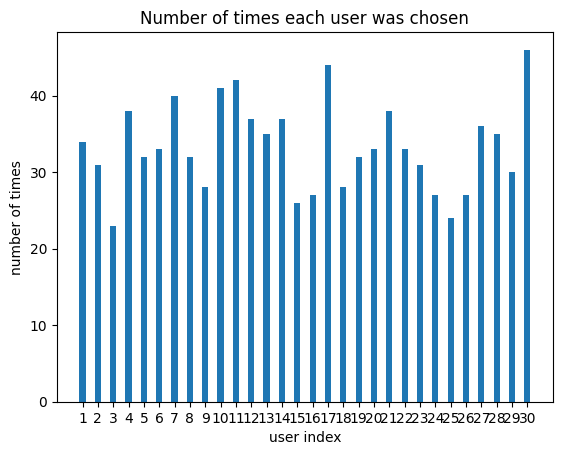

In [4]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
global_epochs_time_list = []


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        print(f"iteration{global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, method=args.method_choosing_users, privacy=False)
    #print(f"choose_users took {time.time()-a}")
    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    for usr_idx in rounds_choise:
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if args.choosing_users_verbose:
            print(f"user {usr_idx}, g: {local_models[usr_idx].g},curr_delay = {local_models[usr_idx].last_access_time}, ucb: {local_models[usr_idx].ucb} num_of_obs: {local_models[usr_idx].num_of_obs}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        print(f"max_delay = {max_delay}")
    
    
    """Part 2: Training"""
    learning_utils.distribute_model(local_models, global_model)
    users_avg_loss_over_local_epochs = []

    for user_idx in rounds_choise:
        user_loss = []
        for local_epoch in range(args.local_epochs):
            user = local_models[user_idx]
            train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
            if args.lr_scheduler:
                user.scheduler.step(train_loss)
            user_loss.append(train_loss)
        users_avg_loss_over_local_epochs.append(mean(user_loss))
    
    avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
    train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)

    #we return deltha_theta only for checking can be removed and fix the return value of the function later on to None
    deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise)
    val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
    val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

    # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
    #                                     "val_loss": val_loss}, time.time()-start_time)
    # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


    time_counter += max_delay
    print((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, avg val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
    global_epochs_time_list.append(time_counter)
    gc.collect()


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model's state dict":global_model.state_dict(),
                    "train_loss_list": train_loss_list,
                    "val_acc_list": val_acc_list,
                    "val_losses_list": val_losses_list,
                    "global_epochs_time_list": global_epochs_time_list,
                    "num_of_users": args.num_users,
                    "num_of_users_per_round": args.num_users_per_round}
                    , path_best_model)
    
    
    torch.save({"model's state dict":global_model.state_dict(),
                "train_loss_list": train_loss_list,
                "val_acc_list": val_acc_list,
                "val_losses_list": val_losses_list,
                "global_epochs_time_list": global_epochs_time_list,
                "num_of_obs_arr": num_of_obs_arr.reshape(-1),
                "global_epoch": global_epoch,
                "num_of_users": args.num_users,
                "num_of_users_per_round": args.num_users_per_round}
                , last_model_path)

    if time_counter > args.max_seconds:
        break

users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
fig, ax = plt.subplots()
ax.bar(users_idxs, num_of_obs_arr.reshape(-1), width = 0.4)
ax.set_title("Number of times each user was chosen")
ax.set_ylabel("number of times")
ax.set_xlabel("user index")
#boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

#choices_table = choices_table.cumsum(axis=0)


In [ ]:
%tensorboard --logdir=runs

In [3]:
utils.plot_graphs({"BSFL brute": r"C:\dev\FL_privacy_mab\checkpoints\good results - mnist 700 trunc\BSFL brute\last_model.pth.tar",
             "random_selection": r"C:\dev\FL_privacy_mab\checkpoints\good results - mnist 700 trunc\random selection\last_model.pth.tar"})

ValueError: too many values to unpack (expected 2)